# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 3 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

from tqdm import trange, tqdm

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if y.size == 0:
        return 0
        
    return np.var(y)

In [3]:
# Test the function
assert np.allclose(H(np.array([4,2,2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    
    x_col = X[:, j]
    
    # Make the split into right and left childs
    y_right = y[x_col > t]
    y_left = y[x_col <= t]
                
    if len(y_right) == 0 or len(y_left) == 0:
        return 0
                
    # Calculate impurity for each child
    impurity_left = H(y_left)
    impurity_right = H(y_right)
    
    Q = 0
    Q += impurity_left * len(y_left) / len(y)
    Q += impurity_right * len(y_right) / len(y)
    
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, criterion = 'default'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
    
    def get_params(self, deep=True):
        """
        Returns class parameters.

        Parameters
        ----------
        deep : boolean
            If True, will return the parameters for this estimator and contained subobjects that are estimators.

        Returns
        -------
        params : dict
            Parameters of the class.
        """

        params = {'max_depth': self.max_depth,
                  'min_samples_split': self.min_samples_split,}

        return params
    
    
    def set_params(self, **params):
        """
        Set class parameters.

        Parameters
        ----------
        params : dict
            Dictionary of the class parameters.
        """

        for key, value in params.items():
            setattr(self, key, value)

        return self
    
    def impurity_calculation(self, y):
        """
        Calculate data impurity.
        
        Parameters
        ----------
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
            
        Returns
        -------
        impurity : float
            Impuroty of the data.
        """
                
        return H(y)
    
    def loss_calculation(self, X, y, j, t):
        return Q(X, y, j, t)
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        best_information_gain = -999
        
        # Data impurity before the split
        impurity = self.impurity_calculation(y)
        # impurity = 0.8 (example)
        
        # For each column in X ...
        for split_column in range(X.shape[1]):
            
            # Select values of the column
            x_col = X[:, split_column]
            # x_col = [2.6, 1.3, 0.5, ...] (example)
            
            # For each value in the column ...
            for i_x in range(0, len(x_col)):
                
                # Take the value as a threshold for a split
                threshold = x_col[i_x]
                
                # TODO: Replace with Q
                information_gain = impurity
                
                Q = self.loss_calculation(X, y, split_column, threshold)
                
                if Q == 0:
                    continue
                    
                information_gain -= self.loss_calculation(X, y, split_column, threshold)
                # information_gain = 0.2 (example)
                
                # Is this information_gain the best?
                if information_gain > best_information_gain:
                    best_split_column = split_column
                    best_threshold = threshold
                    best_information_gain = information_gain
                    
        # If no split available
        if best_information_gain == -999:
            return None, None, None, None, None, None
        
        # Take the best split parameters and make this split
        x_col = X[:, best_split_column]
        X_left = X[x_col <= best_threshold, :]
        y_left = y[x_col <= best_threshold]
        X_right = X[x_col > best_threshold, :]
        y_right = y[x_col > best_threshold]
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
    
    def node_predictions(self, y):
        if y.size == 0:
            return 0
        
        return np.mean(y)
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal =True
            return
                
        # Make best split
        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y) # Make a split
        # split_column = 2 (exmaple) column index of the split
        # threshold = 2.74 (example) split_column > threshold
        
        # Check additional termination conditions
        if split_column is None:
            node.is_terminal = True
            return
        
        # Add split parameters into the current node
        node.column = split_column
        node.threshold = threshold
        
        # Create a left child of the current node
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = self.node_predictions(y_left)
        
        # Create a right child of the current node
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = self.node_predictions(y_right)
        
        # Make splits for the left and right nodes
        self.grow_tree(node.right, X_right, y_right)
        self.grow_tree(node.left, X_left, y_left)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_ = X.shape[1]
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        
        # Termination condition
        if node.is_terminal == True:     # If it is a leaf (terminal node, no childs)
            return node.prediction                           # Return probas of the terminal node
        
        # Run to the current node's childs
        # Check split condition. If yes, go to the right child
        if x[node.column] > node.threshold:
            # Right child
            y_pred = self.get_prediction(node.right, x)
        else: 
            # Left child
            y_pred = self.get_prediction(node.left, x)
            
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

/home/armen/anaconda3/lib/python3.8/site-packages/sklearn/utils/estimator_checks.py:2979: FutureWarning: As of scikit-learn 0.23, estimators should expose a n_features_in_ attribute, unless the 'no_validation' tag is True. This attribute should be equal to the number of features passed to the fit method. An error will be raised from version 0.25 when calling check_estimator(). See SLEP010: https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep010/proposal.html
  warnings.warn(
/home/armen/anaconda3/lib/python3.8/site-packages/sklearn/utils/estimator_checks.py:3021: FutureWarning: As of scikit-learn 0.23, estimators should have a 'requires_y' tag set to the appropriate value. The default value of the tag is False. An error will be raised from version 0.25 when calling check_estimator() if the tag isn't properly set.
  warnings.warn(warning_msg, FutureWarning)


### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

In [8]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
X, y = boston_dataset.data, boston_dataset.target
features = boston_dataset.feature_names

In [9]:
boston = pd.DataFrame(X, columns=boston_dataset.feature_names)
boston['y'] = y
boston.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123) 

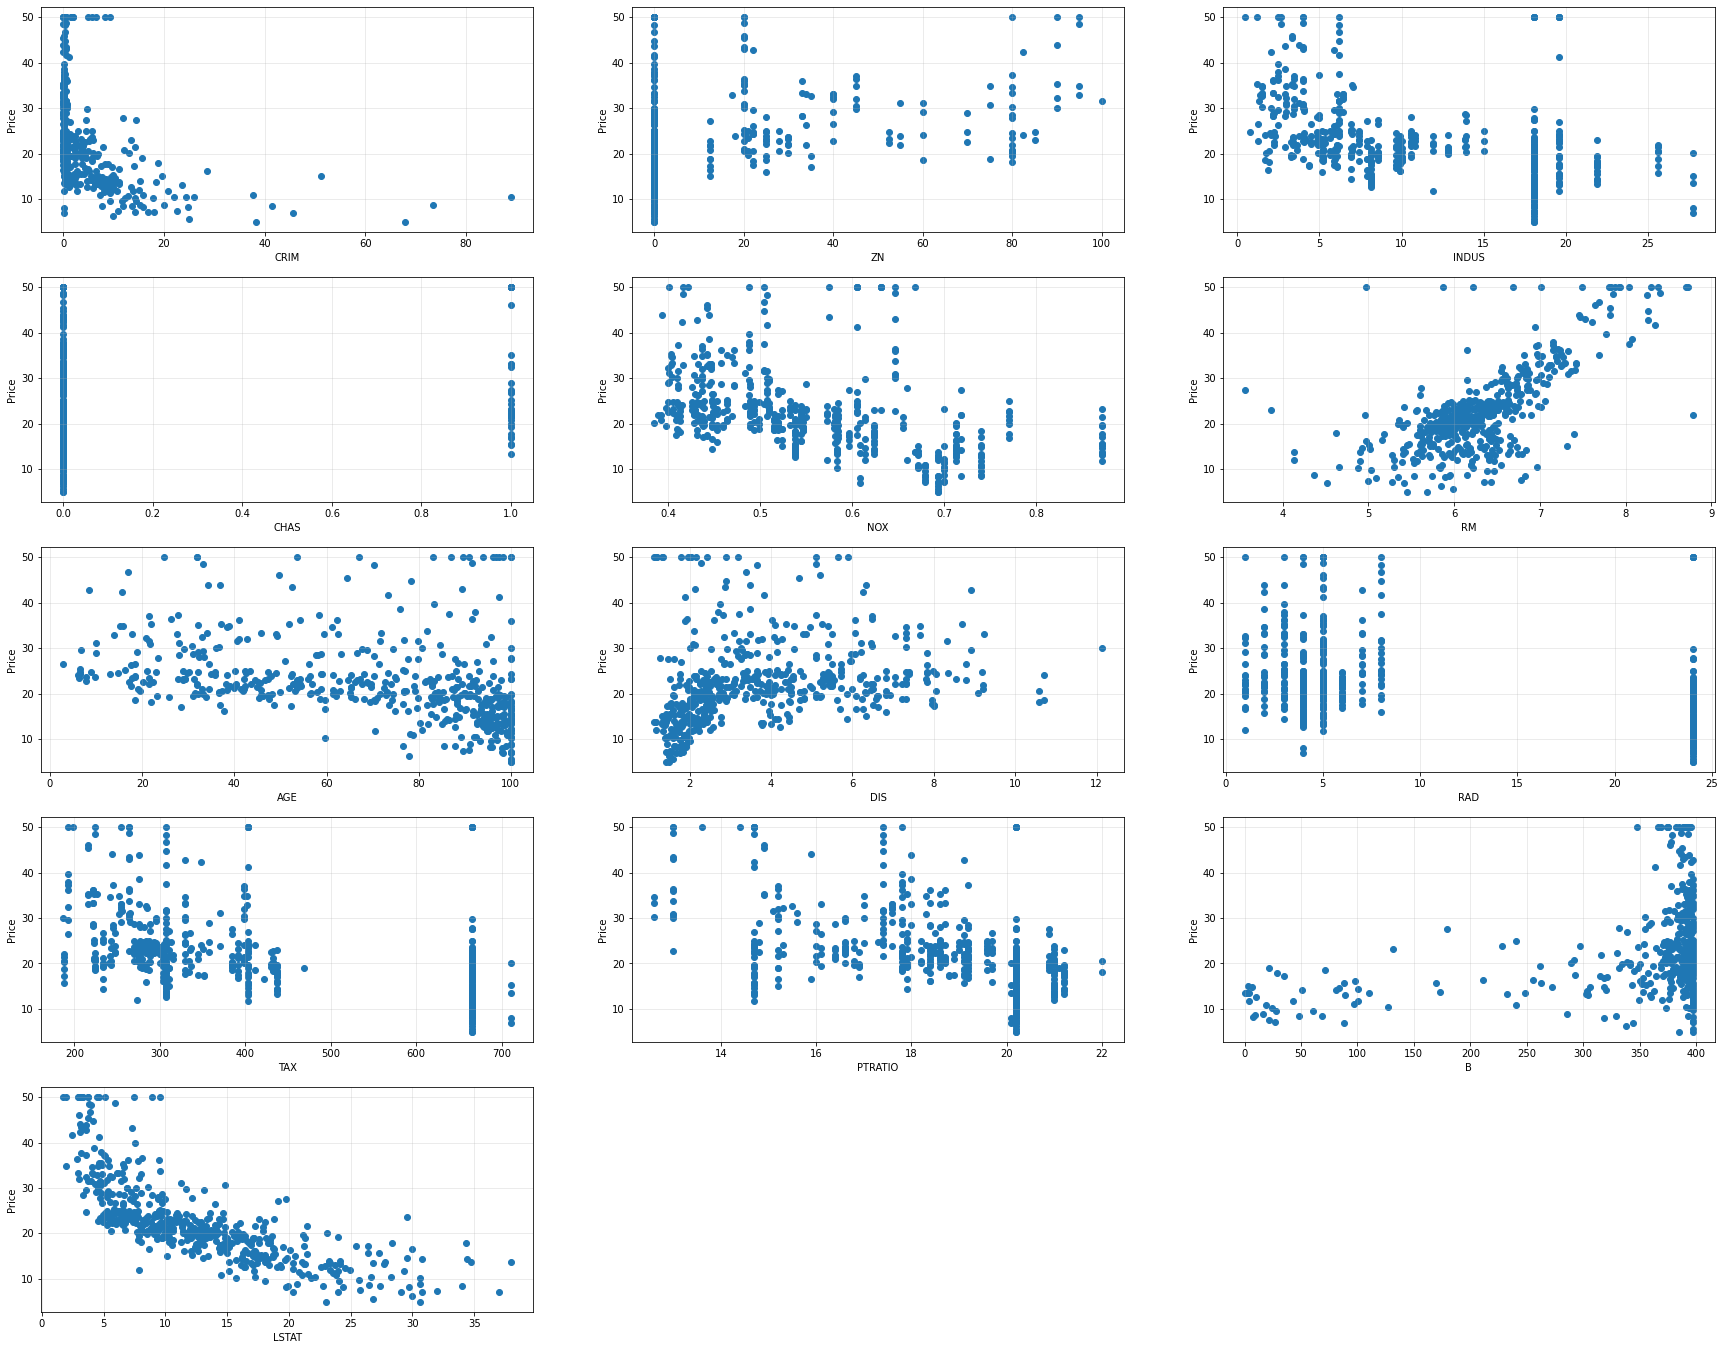

In [11]:
# Define size of the figure
plt.figure(figsize=(30, 24))

# For each column ...
for i_col in range(len(features)):
    
    # Create subplot for each column
    plt.subplot(5, 3, i_col+1)
    
    # Get column and label values
    x_col = boston[features[i_col]].values
    y_col = boston['y'].values
    
    # Plot scatter
    plt.grid(alpha = 0.3)
    plt.scatter(x_col, y_col)
    
    # Labels and legend
    plt.xlabel(features[i_col])
    plt.ylabel('Price')
#     plt.legend(loc='best')
    
plt.show()

In [12]:
# from sklearn.tree import export_graphviz
# import os, graphviz,pydotplus
# #os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# def plot_tree(model, cols, fname='temp_tree.png'):
#     dot_data = export_graphviz(model, filled=True, rounded=True, feature_names=cols, out_file=None)
#     pydot_graph = pydotplus.graph_from_dot_data(dot_data)
#     pydot_graph.write_png(fname)
#     img = plt.imread(fname)
#     plt.imshow(img)

In [13]:
# clf = MyDecisionTreeRegressor(max_depth=2)
# clf.fit(X_train, y_train)
# plt.figure(figsize=(25, 25))
# plt.axis('off')
# plot_tree(clf, features)

In [30]:
clf = MyDecisionTreeRegressor(max_depth=2)
clf.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=2)

In [31]:
print(f"\t\t{clf.tree_.right.prediction}")
print(f"\t{False}")
print(f"X[{clf.tree_.column}] <= {clf.tree_.threshold}")
print(f"\t{True}")
print(f"\t\t{clf.tree_.left.prediction}")

		40.50487804878049
	False
X[5] <= 7.079
	True
		20.437699680511184


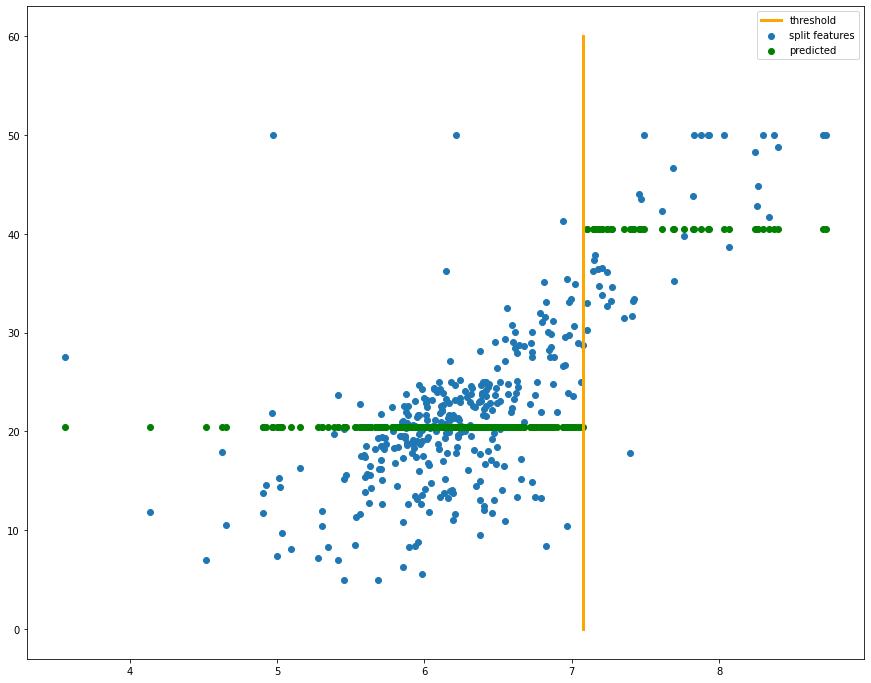

In [35]:
plt.figure(figsize=(15,12))
plt.scatter(X_train[:, clf.tree_.column], y_train, label='split features')
plt.scatter(X_train[:, clf.tree_.column], clf.predict(X_train), c='g', label='predicted')
plt.plot([clf.tree_.threshold, clf.tree_.threshold], [0, y_train.max() + 10], c='orange', label='threshold', linewidth=3)
plt.legend()
plt.show()

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [17]:
# Import GridSearchCV class
from sklearn.model_selection import GridSearchCV

# Define Decision Tree classifier with default parameters
clf = MyDecisionTreeRegressor()

# Estimate grid of the classifier hyperparameters
parameters = {'max_depth':[1, 3, 5, 7, 10], 
              'min_samples_split' : [2,5,10,20]}

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='neg_mean_squared_error',  # Claasification quality metric to optimize
                  cv=5,
                verbose=2,
                 n_jobs=-1)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.3s finished


{'max_depth': 7, 'min_samples_split': 20}

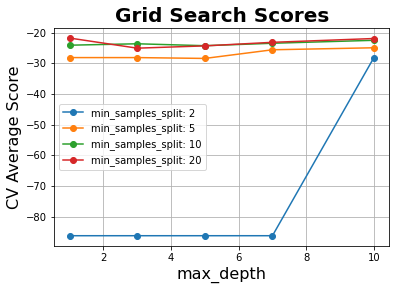

In [18]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best")
    ax.grid('on')

parameters = {'max_depth':[1, 3, 5, 7, 10], 
              'min_samples_split' : [2,5,10,20]}

# Calling Method 
plot_grid_search(gs.cv_results_, parameters['max_depth'], parameters['min_samples_split'], 'max_depth', 'min_samples_split')

In [19]:
def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y_hat, y))

In [20]:
pred = gs.predict(X_test)
print('RMSE: ', round(rmse(y_test, pred),3))

RMSE:  4.466


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [58]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    for i in range(n_iter):
        values = np.array(range(len(x)))
        train = resample(values, n_samples=int(len(x)*0.5))
        test = values[np.in1d(values, train, invert=True)]
        
        estimator.fit(x[train], y[train])
        preds = estimator.predict(x[test])
        
        avg = preds.mean()
        bias = np.power((y - avg), 2)
        variance = np.var(preds)
        
    return bias.mean(), variance.mean()

In [59]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(85.78984758129789, 91.76491576460982)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

In [63]:
depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bias = []
variance = []

for d in tqdm(depths):
    estimator = MyDecisionTreeRegressor(max_depth=d, min_samples_split=15)
    _b, _v = get_bias_variance(estimator, X_train, y_train, 10)
    
    bias.append(_b)
    variance.append(_v)

100%|██████████| 9/9 [00:50<00:00,  5.65s/it]


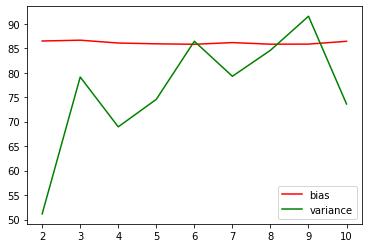

In [64]:
plt.plot(depths, bias, c='r', label='bias')
plt.plot(depths, variance, c = 'g', label = 'variance')
plt.legend()
plt.show()

It can be seen that variance is falling and rising and it is difficult to say something. As for bias the change is not noticable, it remains almost the same.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [68]:
from sklearn.ensemble import BaggingRegressor

model = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)
estimator = BaggingRegressor(base_estimator=model, n_jobs=-1, n_estimators=100)
get_bias_variance(estimator, X_train, y_train, 10)

(86.2801520870727, 73.46797501443903)

Generally, deep trees have greater variance and lower bias, as they are more likely become overtrained and better find some paterns in data.
BaggingRegressor can be used to low the variance, but bias gots a little bit higher, it can be seen in the experiment above, as we compare result from task 6 with this one. By lowering the depth we can achieve better results, but only for this dataset and parameters, as for other ones it cant be false.

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [88]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [89]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [90]:
X.isna().sum()

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
dtype: int64

In [91]:
alpha = 0.2
X = X.loc[:, X.isna().mean() < alpha]

Dropping all columns with nan, which percentage is higher than 20%.

In [92]:
X.isna().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH_measured                   0
TSH                          369
T3_measured                    0
TT4_measured                   0
TT4                          231
T4U_measured                   0
T4U                          387
FTI_measured                   0
FTI                          385
TBG_measured                   0
referral_source                0
dtype: int64

In [96]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


column_transformer = ColumnTransformer(
[('category', OneHotEncoder(dtype='object'),['sick']),
# ('title_bow', CountVectorizer(), 'title')
],
remainder='passthrough')

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. Choose one of the tree popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [ ]:
# YOUR CODE HERE